In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
from pycbc.types import timeseries
from scipy.interpolate import LinearNDInterpolator
from scipy.optimize import curve_fit, minimize
from calcwf import *
import matplotlib as mpl
from matplotlib import colors
from interpolating_match import *

In [2]:
sample_rate = 4096

# Find min/max lines

Let's first find the minimum and maximum lines for each chirp mass and add them to the dictionary for ease of use.

In [3]:
def min_max_plot(data, param_vals=np.linspace(0,0.2,101), fid_e=0.1):

    # Plot setup
    plt.figure(figsize=(6.4*3, 4.8))
    match_names = ['h0', 'h1', 'h1/h0']
    n = len(data.keys())
    cmap = mpl.colormaps['inferno']
    
    # Loop over each chirp mass grid
    for i, chirp in enumerate(data.keys()):

        # Get param vals if available from data
        if i==0 and 'e_vals' in data[chirp].keys():
            param_vals = data[chirp]['e_vals']

        # Loop over h0, h1, h1/h0
        for j, key in enumerate(['h1', 'h2', 'h2_h1']):

            # Select subplot
            plt.subplot(1, 3, j+1)

            # Plotting min/max amplitude of matches along degen line
            plt.plot(param_vals, data[chirp][f'{key}_max'], label='$\mathcal{M}=$'+str(chirp), c=cmap(i/n), alpha=0.7, zorder=5)
            plt.plot(param_vals, data[chirp][f'{key}_min'], c=cmap(i/n), alpha=0.7, zorder=5)
            plt.axvline(fid_e, c='k', ls='dashed', zorder=5, alpha=0.7)
            ylim = plt.gca().get_ylim()
            plt.axhline(1, c='k', ls='dashed', zorder=5, alpha=0.7)
            plt.ylim(ylim)
            plt.xlabel('ecc')
            plt.ylabel('match')
            plt.title(match_names[j])
            plt.legend()
            plt.xlim(param_vals[0], param_vals[-1])

In [4]:
with open(os.path.join('grid_data', 'dataslot_3', 'all_matches'), 'rb') as fp:
        grid_data_20_30_5 = pickle.load(fp)
grid_data_20_30_5 = find_min_max(grid_data_20_30_5)

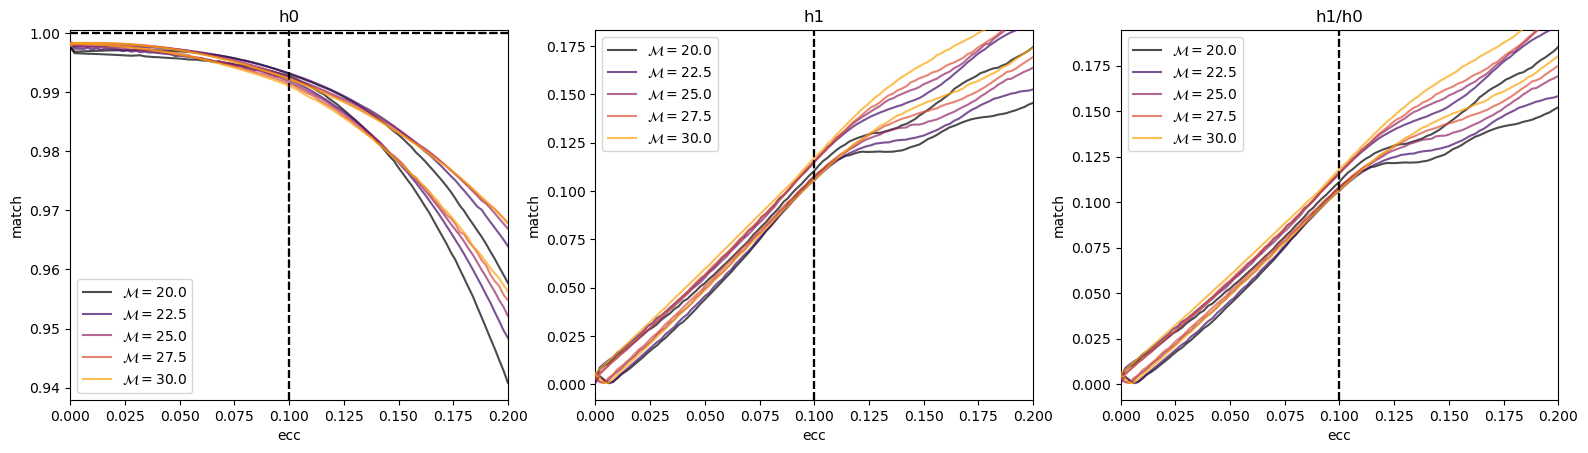

In [5]:
min_max_plot(grid_data_20_30_5)

# 2D interpolation

Next create 2D interpolation object which takes an arbitrary chirp mass value (within range), and values of eccentricity along the line of degeneracy, and returns the match of the min/max lines. Wil need to create six objects - one for the min and max line of each of the three plots.

In [7]:
def create_2D_interps_test_plot(interp_chirp, interps, true_data=None, param_vals=np.linspace(0, 0.2, 101), fid_e=0.1):

    # Plot setup
    plt.figure(figsize=(6.4*3, 4.8))
    match_names = ['h0', 'h1', 'h1/h0']

    # Loop over h0, h1, h1/h0
    for i, key in enumerate(['h1', 'h2', 'h2_h1']):

        # Select subplot
        plt.subplot(1, 3, i+1)

        # True max/min plot
        if true_data is not None:
            plt.plot(param_vals, true_data[interp_chirp][f'{key}_max'], label='Calculated', c='r', alpha=0.7, zorder=5)
            plt.plot(param_vals, true_data[interp_chirp][f'{key}_min'], c='r', alpha=0.7, zorder=5)
            
        # Interpolate max/min plot
        plt.plot(param_vals, interps[i][0](interp_chirp, param_vals), label='Interpolated', c='b', alpha=0.7, zorder=5)
        plt.plot(param_vals, interps[i][1](interp_chirp, param_vals), c='b', alpha=0.7, zorder=5)
        
        # Plot formatting
        ylim = plt.gca().get_ylim()
        plt.axvline(fid_e, c='k', ls='dashed', zorder=5, alpha=0.7)
        plt.axhline(1, c='k', ls='dashed', zorder=5, alpha=0.7)
        plt.ylim(ylim)
        plt.xlabel('ecc')
        plt.ylabel('match')
        plt.title('$e_{10}=$'+str(fid_e)+', $\mathcal{M}=$'+f'{interp_chirp}, {match_names[i]}')
        plt.legend()
        plt.xlim(param_vals[0], param_vals[-1])

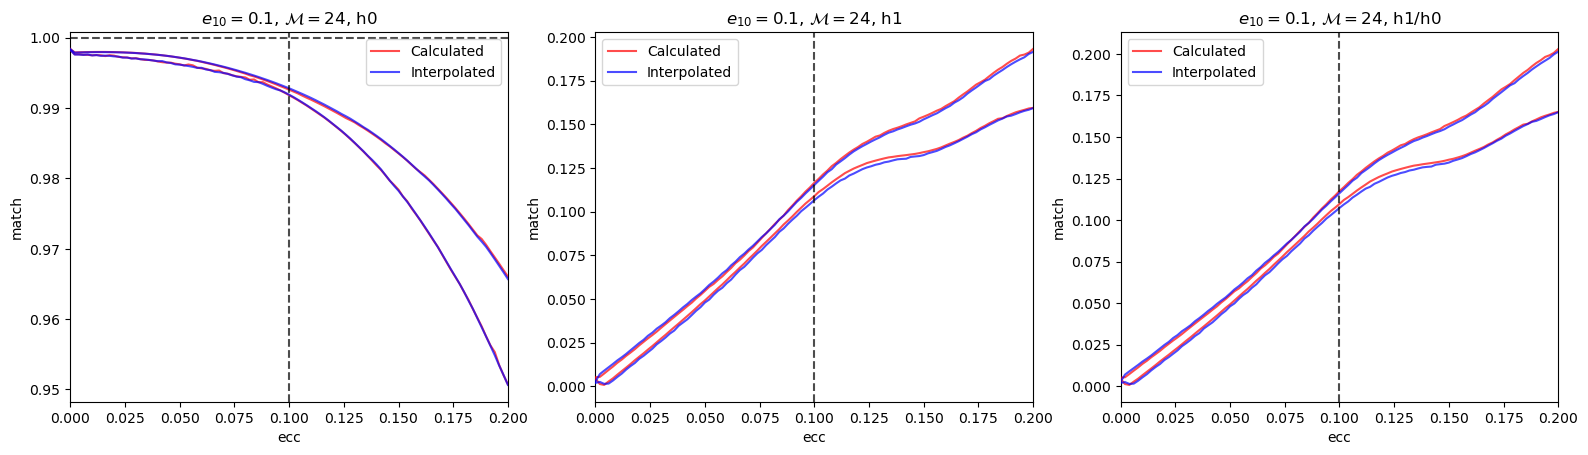

In [9]:
with open(os.path.join('grid_data', 'dataslot_4', 'all_matches'), 'rb') as fp:
    grid_data_24_25_2 = pickle.load(fp)
grid_data_24_25_2 = find_min_max(grid_data_24_25_2)
create_2D_interps_test_plot(24, grid_data_20_30_5_interps, true_data=grid_data_24_25_2)

In [23]:
find_ecc_range(0.162, 24, grid_data_20_30_5_interps[2])

(0.15828125000000018, 0.2)

Interpolation seems to have worked quite well, biggest discrepancy is the minimum line in h1, h1/h0 at an eccentriciy of 0.125. Will try 21 chirp mass test case as well.

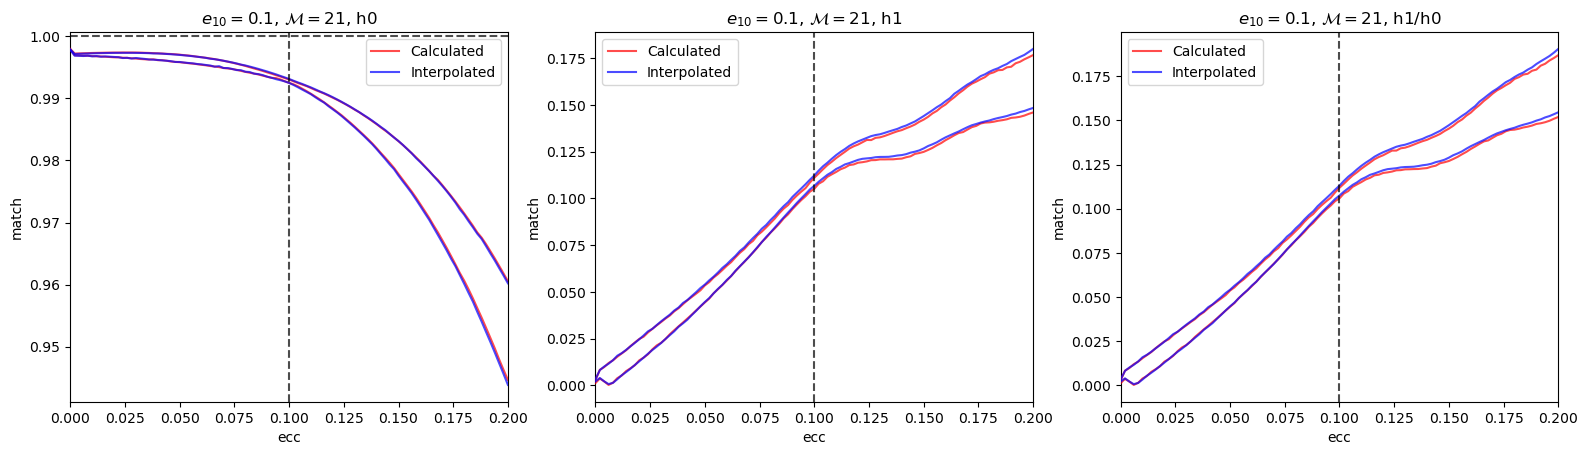

In [10]:
with open(os.path.join('grid_data', 'dataslot_7', 'all_matches'), 'rb') as fp:
    grid_data_21 = pickle.load(fp)
grid_data_21 = find_min_max(grid_data_21)
create_2D_interps_test_plot(21, grid_data_20_30_5_interps, true_data=grid_data_21)

Again approximates calculated lines fairly well, could likely be improved even further with a denser chirp mass grid range.

# Eccentricity range

Finally we must convert a given match value to an eccentricity range. Will test this by calculating the range for h0, h1, h1/h0 for a range of 11 values of eccentricity for 24 chirp mass. For real data, can only use the range given by h1/h0, however the other two can be used here to check self-consistency of our method.

In [11]:
def find_ecc_range_test_plot(ecc_vals, fid_M, interps, n, f_low=10, fid_e=0.1, q=2, xlim=(0, 0.2)):

    # Find degen line using favata et al.
    chirp_vals = favata_et_al_avg(fid_e, fid_M, ecc_vals, sample_rate, f_low=f_low, q=q)

    # Generate fiducial waveform
    all_wfs = list(get_h([1]*n, f_low, fid_e, chirp2total(fid_M, q), q, sample_rate))
    wf_hjs = all_wfs[1:n+1]

    # Generate trial waveforms at random MA and calculate ecc range from matches
    h0_ecc_ranges = []
    h1_ecc_ranges = []
    h1_h0_ecc_ranges = []
    for ecc, chirp_M in zip(ecc_vals, chirp_vals):
        s_f_2pi = f_low - shifted_f(f_low, ecc, chirp2total(chirp_M, q), q)
        s_f = f_low - np.random.rand()*s_f_2pi
        s_e = shifted_e(s_f, f_low, ecc)
        h = gen_wf(s_f, s_e, chirp2total(chirp_M, q), q, sample_rate, 'TEOBResumS')
        all_matches = match_hn(wf_hjs, h, f_low)
        h0_ecc_ranges.append(find_ecc_range(abs(all_matches[0]), fid_M, interps[0], slope='decreasing'))
        h1_ecc_ranges.append(find_ecc_range(abs(all_matches[1]), fid_M, interps[1], slope='increasing'))
        h1_h0_ecc_ranges.append(find_ecc_range(abs(all_matches[1])/abs(all_matches[0]), fid_M, interps[2], slope='increasing'))
    ecc_ranges = [h0_ecc_ranges, h1_ecc_ranges, h1_h0_ecc_ranges]

    # Get colours for plt.fill_between and plot setup
    ecs = []
    fcs = []
    leg_names = ['h0', 'h1', 'h1/h0']
    for i in range(3):
        ec = list(colors.to_rgba(f'C{i}'))
        ecs.append(ec)
        fc = ec.copy()
        fc[-1] = 0.4
        fcs.append(fc)
    plt.figure(figsize=(6.4*3, 4.8))

    # Loop over h0, h1, h1/h0
    for i in range(3):

        # Select subplot
        plt.subplot(1, 3, i+1)
        
        # Plot all true values
        plt.scatter(ecc_vals, np.arange(len(ecc_vals)), c='r', label='True values', zorder=3)
    
        # Plot all ecc ranges
        for j in range(len(ecc_vals)):
            plt.fill_between(ecc_ranges[i][j], j-0.35, j+0.35, facecolor=fcs[i], edgecolor=ecs[i])
    
        # Plot formatting
        plt.plot(1, 1, c=f'C{i}', label=f'{leg_names[i]} estimate')
        plt.legend(loc='upper left')
        plt.xlim(xlim)
        plt.gca().get_yaxis().set_visible(False)
        plt.xlabel('Eccentricity')
        plt.title('$e_{10}=$'+str(fid_e)+', $\mathcal{M}=$'+f'{fid_M}, {leg_names[i]}')

/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


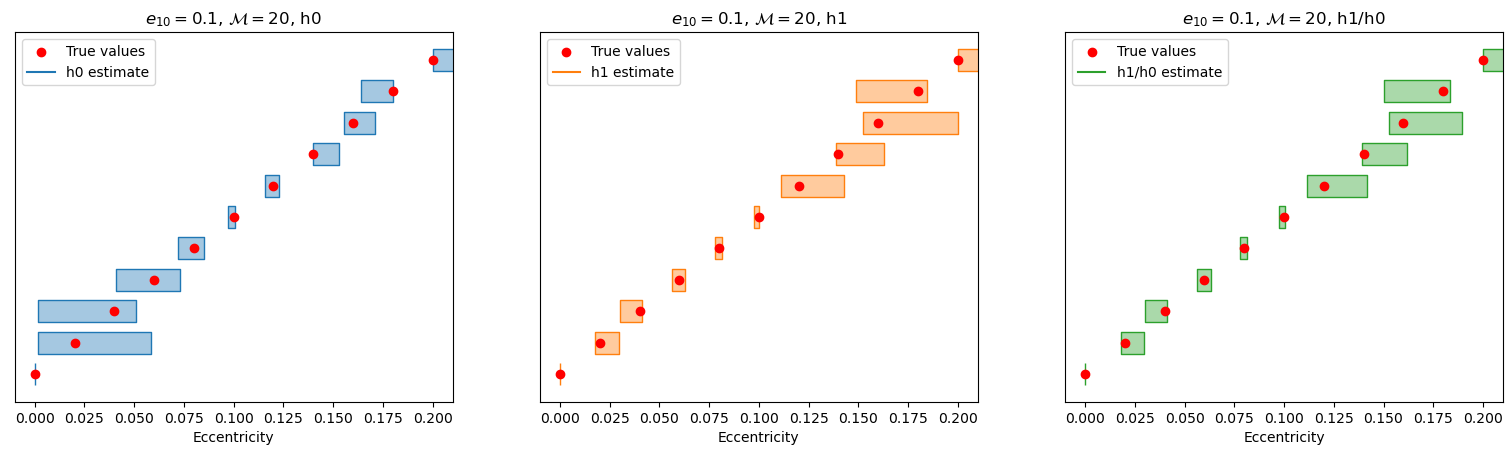

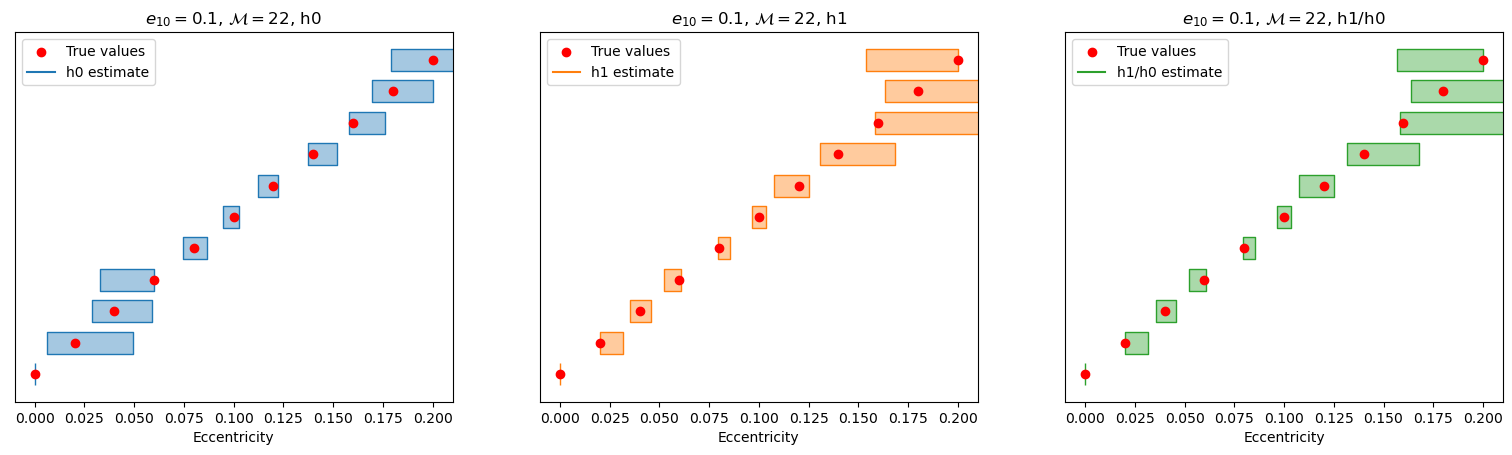

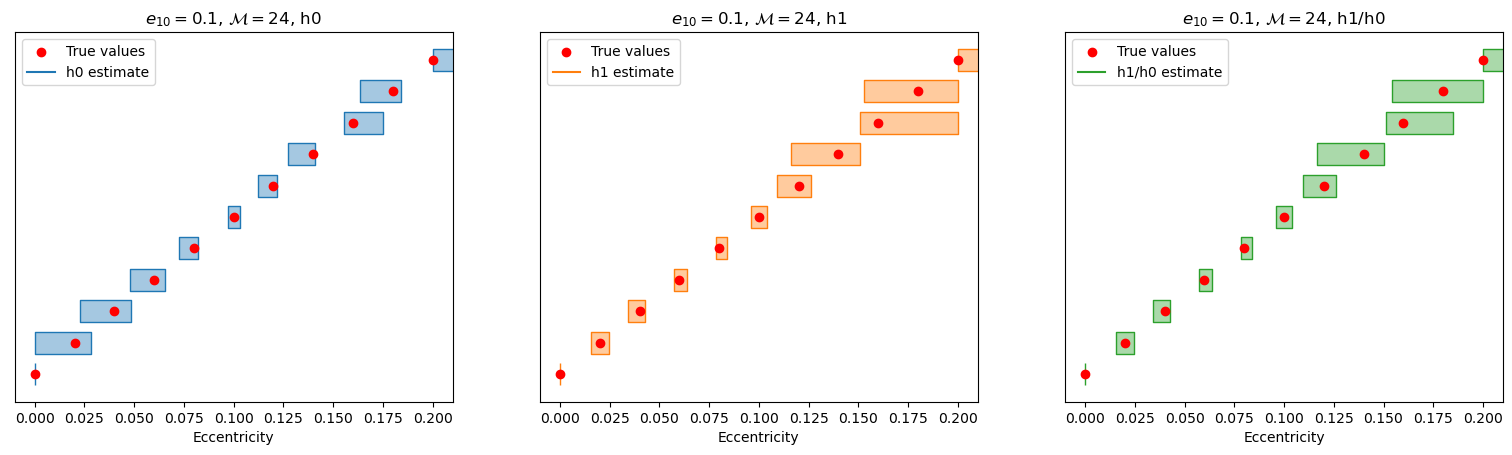

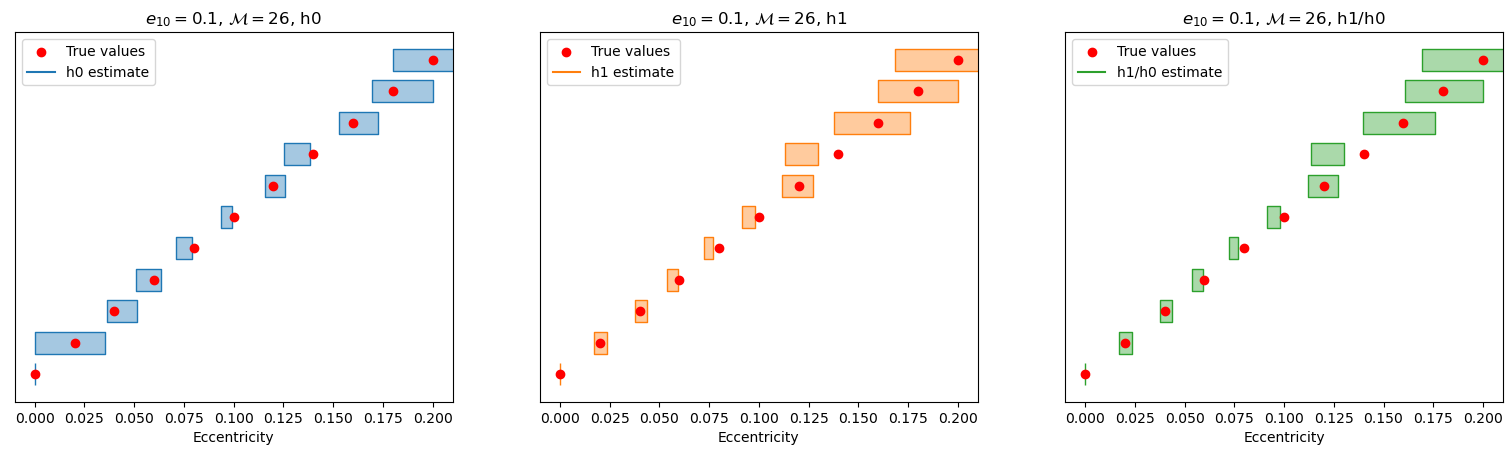

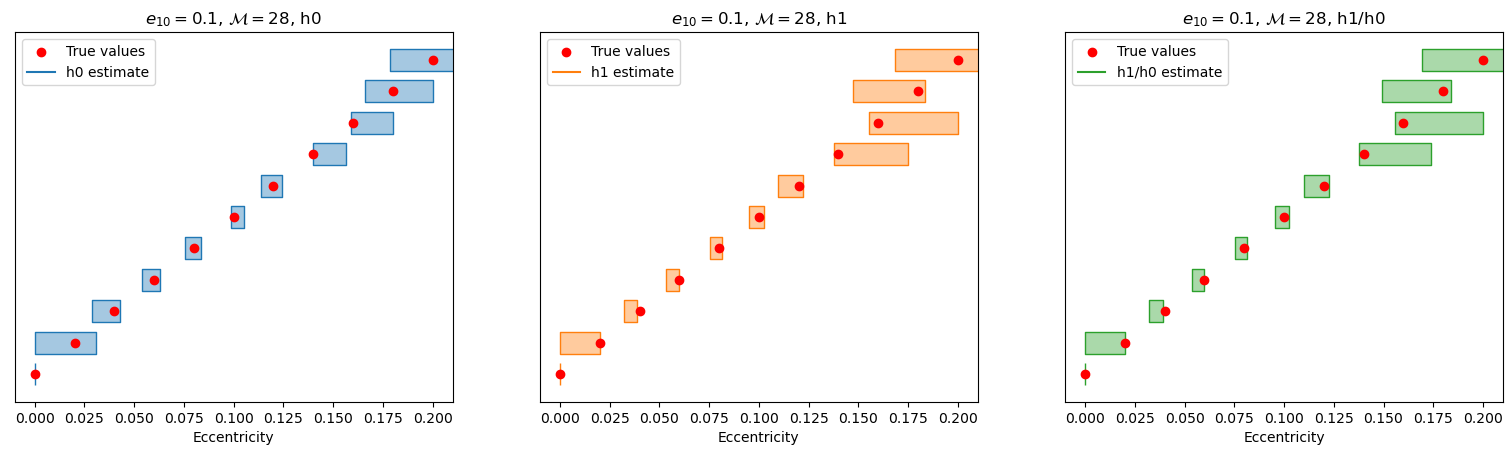

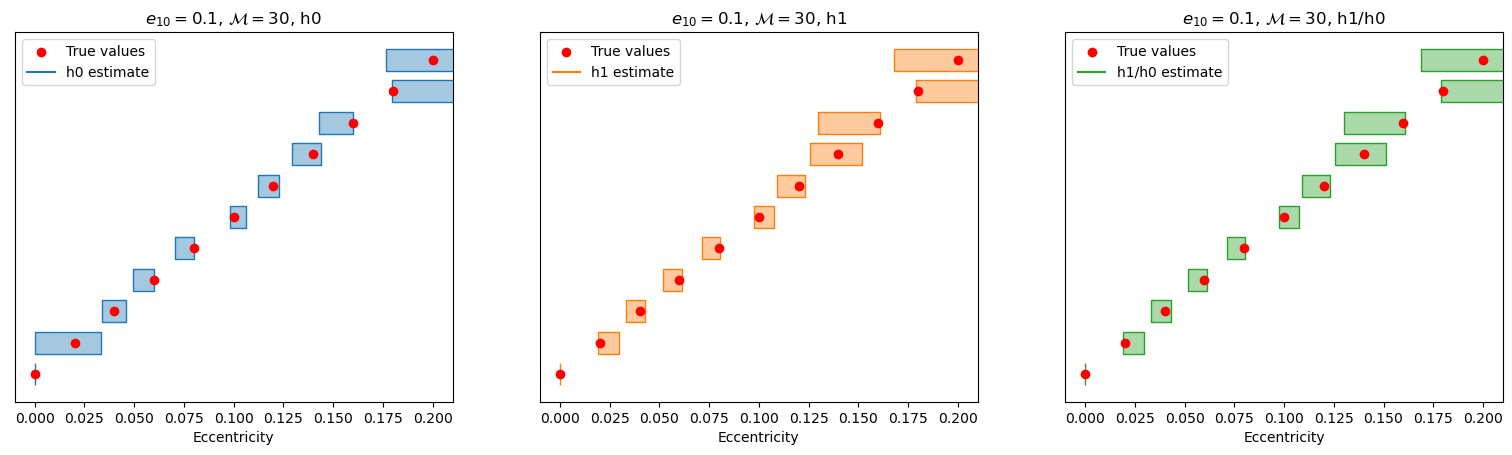

In [12]:
for i in range(6):
    find_ecc_range_test_plot(np.linspace(0,0.2,11), 20+2*i, grid_data_20_30_5_interps, 4, xlim=(-0.01, 0.21))
    plt.show()

Seems to work fairly robustly at a range of chirp masses. There are a few data points where the true is slightly outside the recovered range - likely due to inaccuracies in the interpolation. Especially where the ranges are large, a small inaccuracy in the interpolation can cause a fairly large inaccuracy in the range due to the slope of the match against ecc plot being fairly flat.

28 chirp mass grid in particular seems to suffer from this, so calculating true min/max lines now to compare.

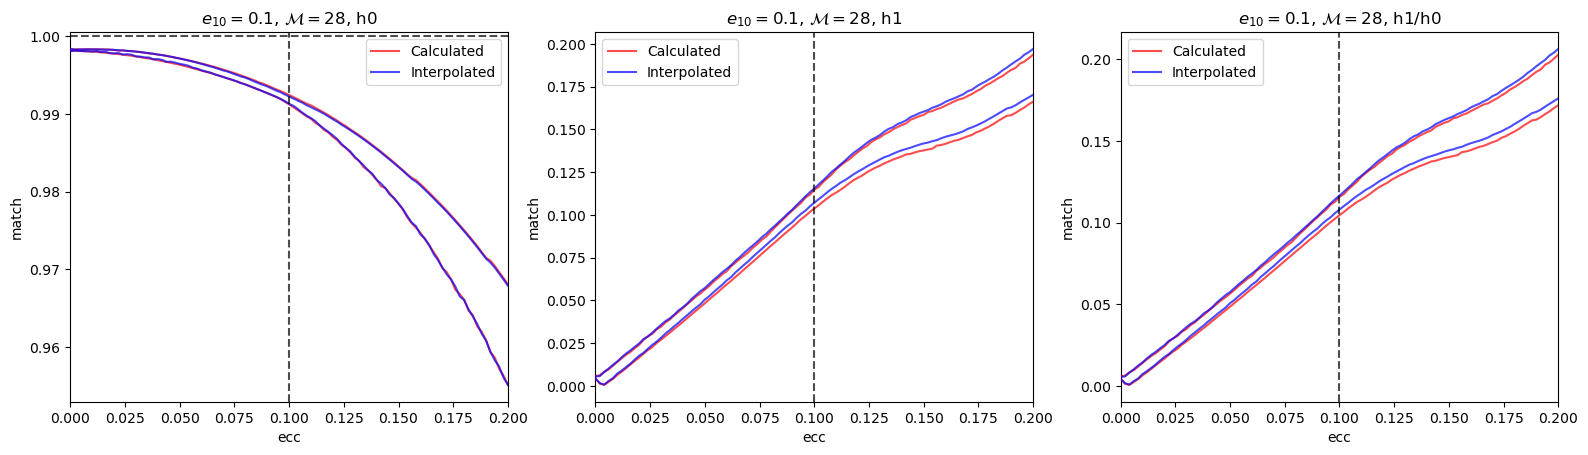

In [13]:
with open(os.path.join('grid_data', 'dataslot_8', 'all_matches'), 'rb') as fp:
    grid_data_22_28_4 = pickle.load(fp)
grid_data_22_28_4 = find_min_max(grid_data_22_28_4)
create_2D_interps_test_plot(28, grid_data_20_30_5_interps, true_data=grid_data_22_28_4)

We do indeed see a slight offset for especially the min line in the h1 and h1/h0 plots, which is the likely cause of the slight offsets we are seeing, both for this chirp mass and others.

# Dense grid

As we have the dense grid (24.0, 24.1, 24.2, 24.3, 24.4, 24.5) from attempts to interpolate over the phase difference, we may as well use it here and see how plots look with it.

In [13]:
with open(os.path.join('grid_data', 'dataslot_5', 'all_matches'), 'rb') as fp:
        grid_data_24_24p5_6 = pickle.load(fp)
grid_data_24_24p5_6 = find_min_max(grid_data_24_24p5_6)

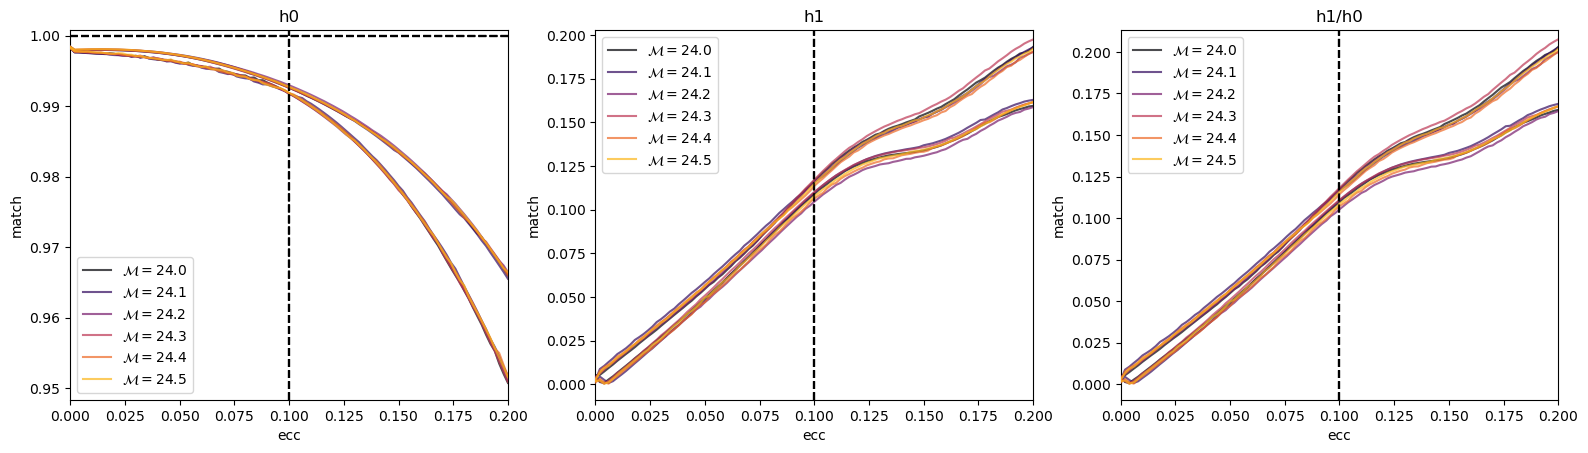

In [14]:
min_max_plot(grid_data_24_24p5_6)

Very little difference between lines here as expected.

In [15]:
grid_data_24_24p5_6_interps = create_2D_interps(grid_data_24_24p5_6)

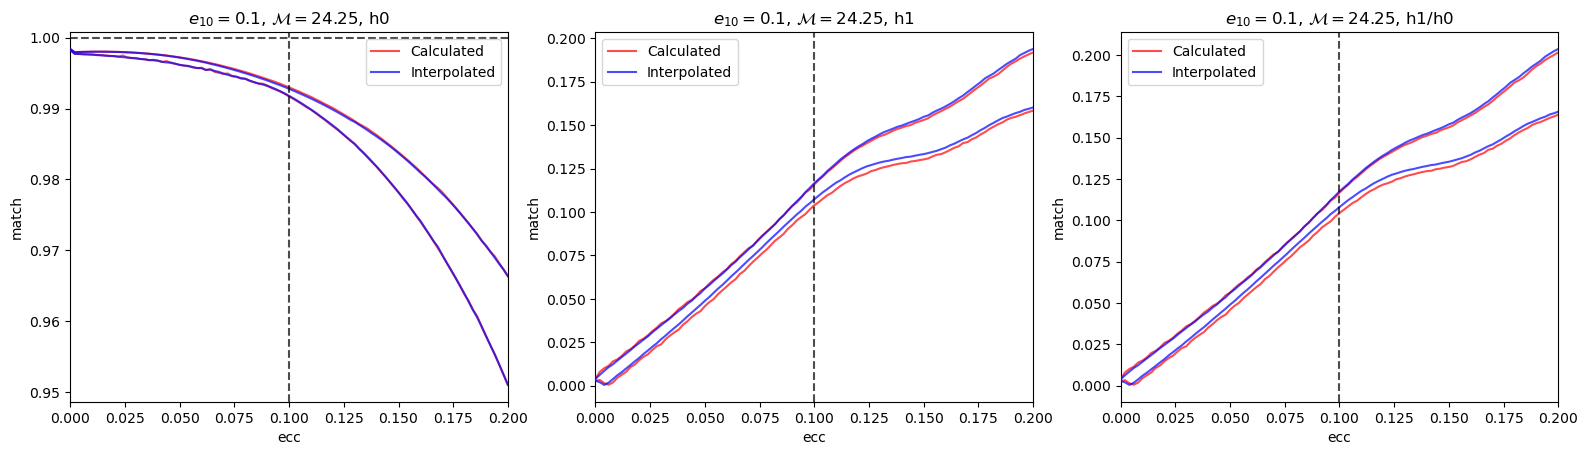

In [16]:
with open(os.path.join('grid_data', 'dataslot_6', 'all_matches'), 'rb') as fp:
    grid_data_24p25 = pickle.load(fp)
grid_data_24p25 = find_min_max(grid_data_24p25)
create_2D_interps_test_plot(24.25, grid_data_24_24p5_6_interps, true_data=grid_data_24p25)

There is a constant difference here in h1, h1/h0 plots. The shape of all lines in the first plot above are the same, but they do move around slightly, suggesting this may be an inherent uncertainty in our interpolation method.

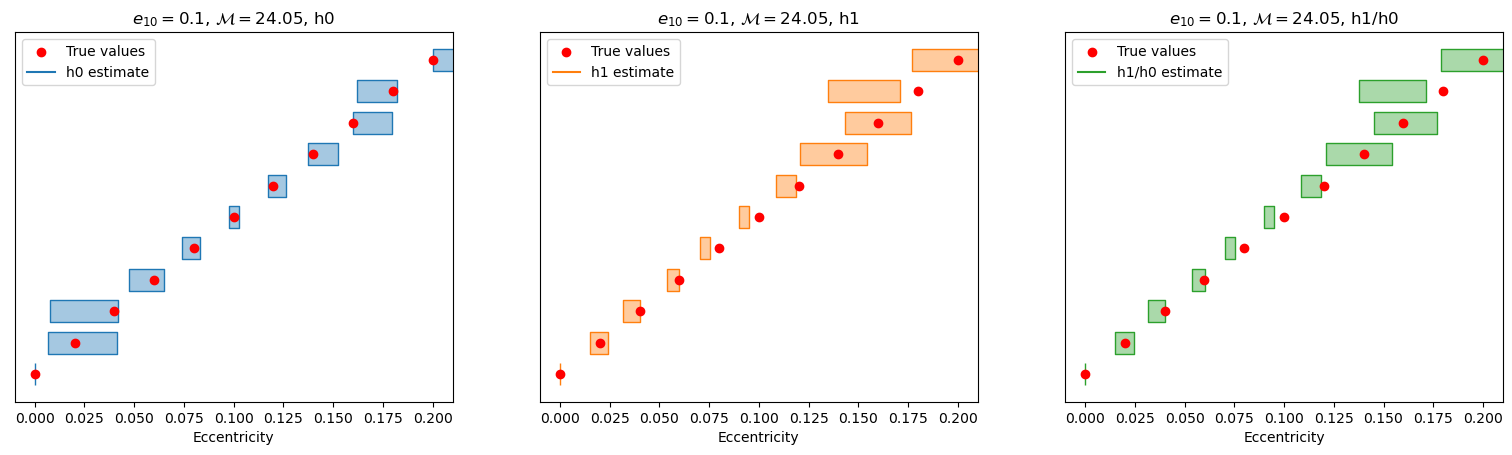

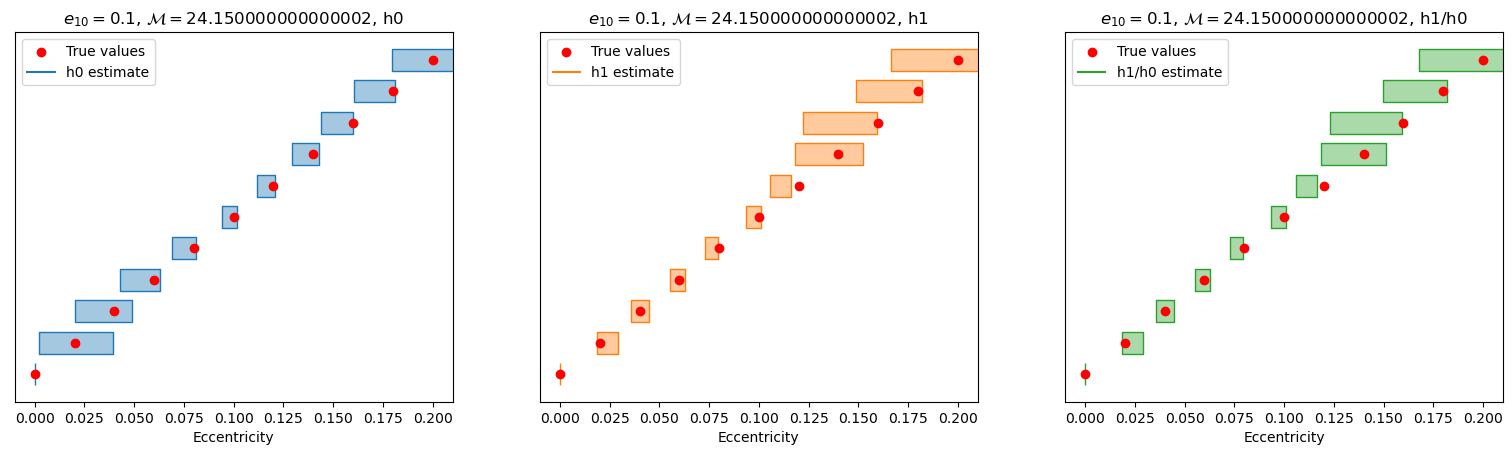

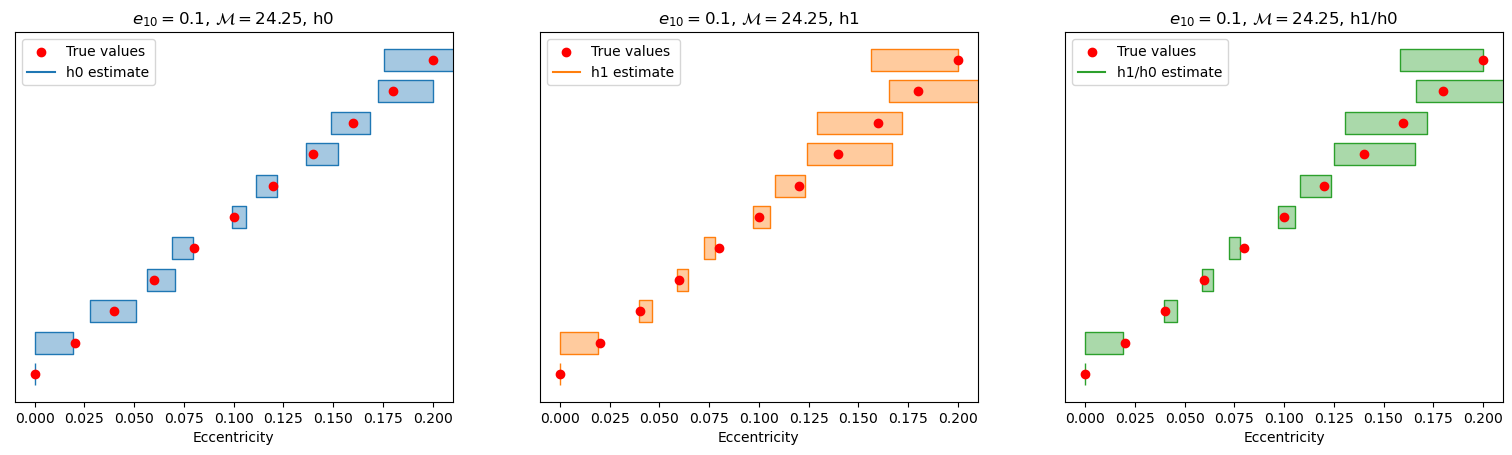

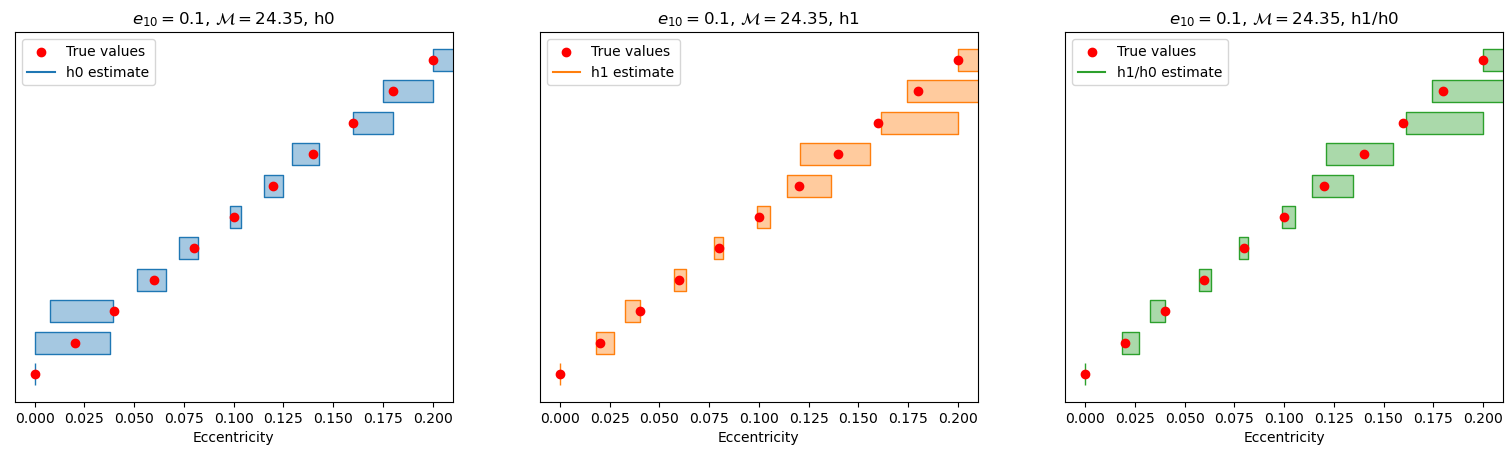

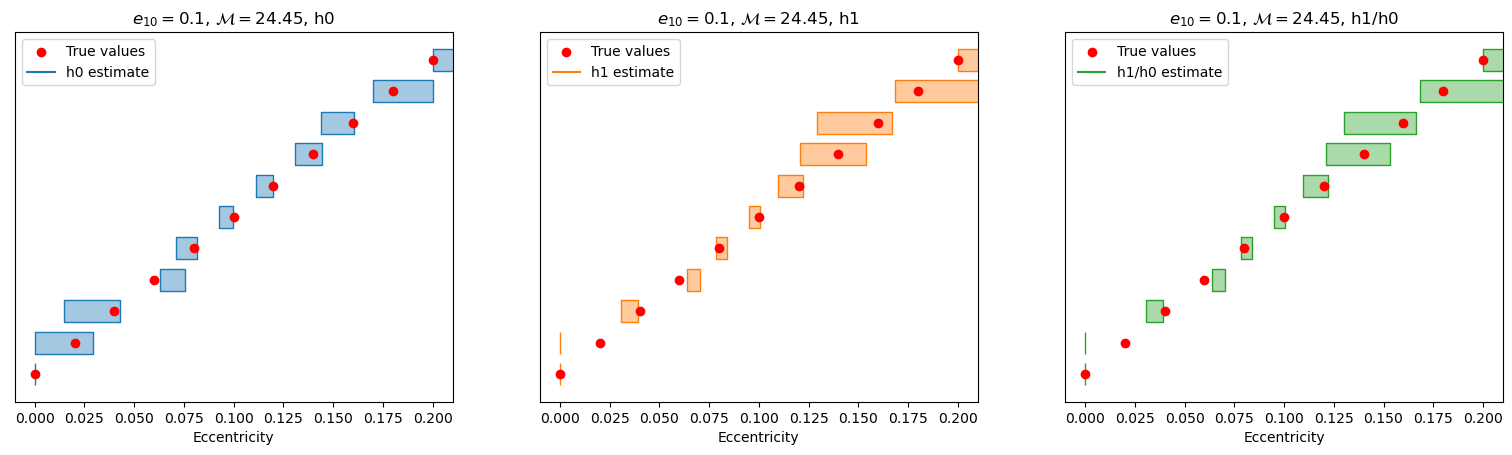

In [17]:
for i in range(5):
    find_ecc_range_test_plot(np.linspace(0,0.2,11), 24.05+i*0.1, grid_data_24_24p5_6_interps, 4, xlim=(-0.01, 0.21))
    plt.show()

Looks fairly similar to our sparser grid, suggesting that improving the density of chirp mass grids will not aid significantly in finding eccentricity ranges in this way.

# Higher eccentricity

In [3]:
with open(os.path.join('grid_data', 'dataslot_9', 'all_matches'), 'rb') as fp:
        grid_data_20_30_5_he = pickle.load(fp)
grid_data_20_30_5_he = find_min_max(grid_data_20_30_5_he)

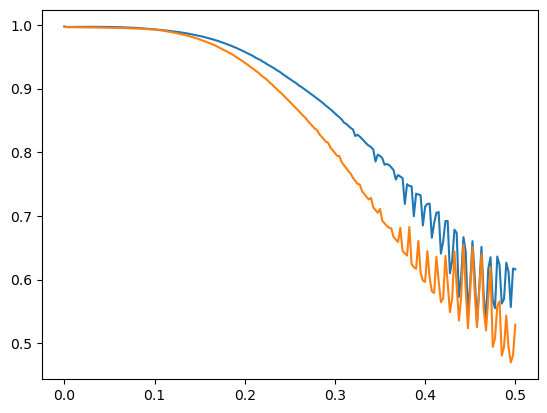

In [14]:
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.max(grid_data_20_30_5_he[20]['h1'], axis=1))
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.min(grid_data_20_30_5_he[20]['h1'], axis=1))

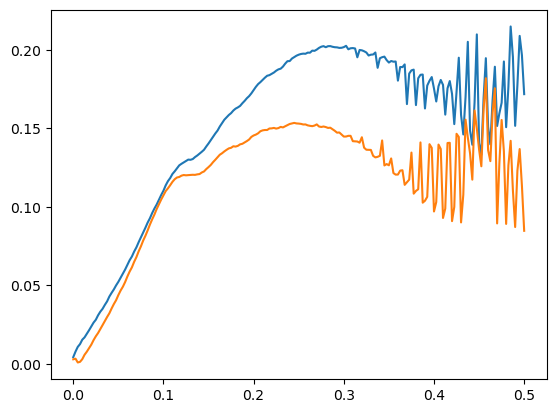

In [5]:
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.max(grid_data_20_30_5_he[20]['h2'], axis=1))
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.min(grid_data_20_30_5_he[20]['h2'], axis=1))

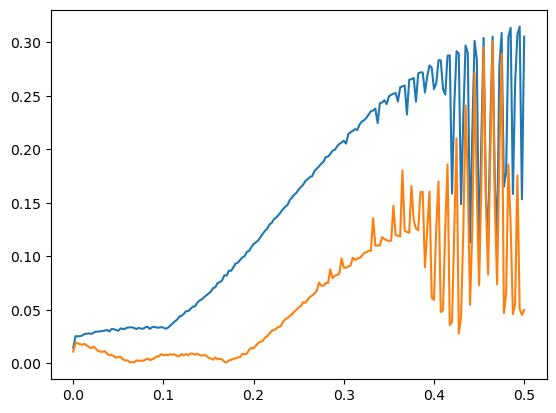

In [4]:
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.max(grid_data_20_30_5_he[20]['h3'], axis=1))
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.min(grid_data_20_30_5_he[20]['h3'], axis=1))

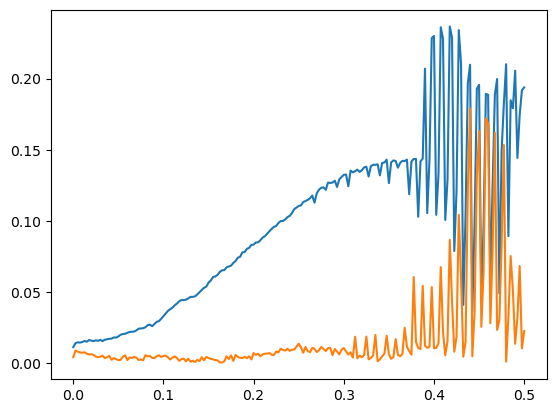

In [9]:
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.max(grid_data_20_30_5_he[20]['h4'], axis=1))
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.min(grid_data_20_30_5_he[20]['h4'], axis=1))

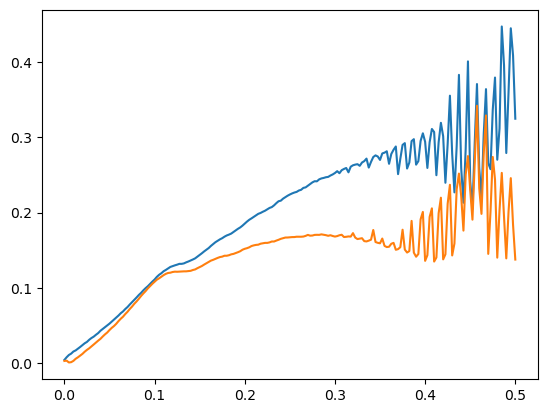

In [18]:
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.max(grid_data_20_30_5_he[20]['h2'], axis=1)/np.min(grid_data_20_30_5_he[20]['h1'], axis=1))
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.min(grid_data_20_30_5_he[20]['h2'], axis=1)/np.max(grid_data_20_30_5_he[20]['h1'], axis=1))

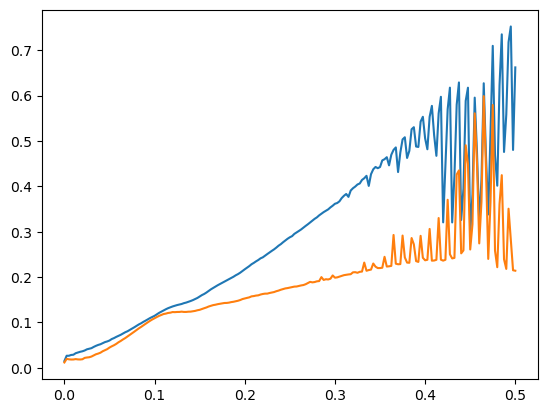

In [12]:
h1_h2 = np.sqrt(grid_data_20_30_5_he[20]['h2']**2+grid_data_20_30_5_he[20]['h3']**2)
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.max(h1_h2, axis=1)/np.min(grid_data_20_30_5_he[20]['h1'], axis=1))
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.min(h1_h2, axis=1)/np.max(grid_data_20_30_5_he[20]['h1'], axis=1))

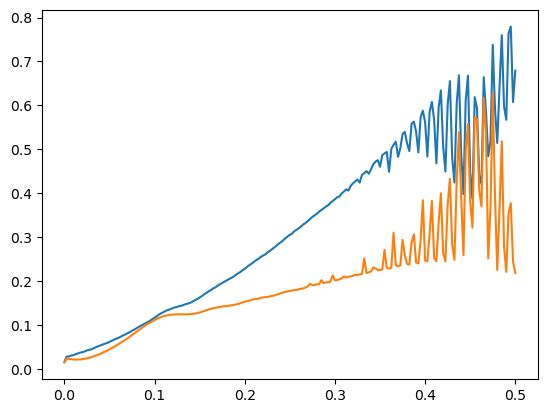

In [13]:
h1_h2_h3 = np.sqrt(grid_data_20_30_5_he[20]['h2']**2+grid_data_20_30_5_he[20]['h3']**2+grid_data_20_30_5_he[20]['h4']**2)
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.max(h1_h2_h3, axis=1)/np.min(grid_data_20_30_5_he[20]['h1'], axis=1))
plt.plot(grid_data_20_30_5_he[20]['e_vals'], np.min(h1_h2_h3, axis=1)/np.max(grid_data_20_30_5_he[20]['h1'], axis=1))

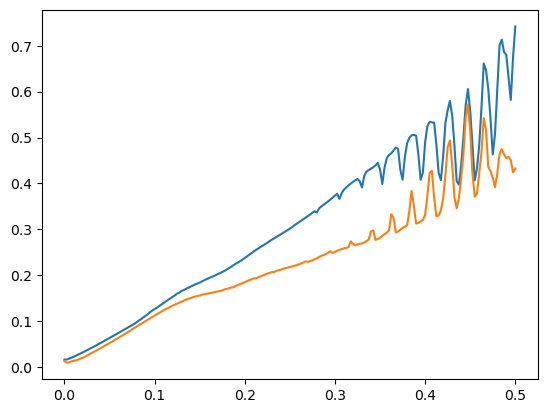

In [16]:
h1_h2_h3 = np.sqrt(grid_data_20_30_5_he[30]['h2']**2+grid_data_20_30_5_he[30]['h3']**2+grid_data_20_30_5_he[30]['h4']**2)
plt.plot(grid_data_20_30_5_he[30]['e_vals'], np.max(h1_h2_h3, axis=1)/np.min(grid_data_20_30_5_he[30]['h1'], axis=1))
plt.plot(grid_data_20_30_5_he[30]['e_vals'], np.min(h1_h2_h3, axis=1)/np.max(grid_data_20_30_5_he[30]['h1'], axis=1))

In [8]:
with open(os.path.join('grid_data', 'dataslot_10', 'all_matches'), 'rb') as fp:
        grid_data_20_30_5_hfe = pickle.load(fp)
grid_data_20_30_5_hfe = find_min_max(grid_data_20_30_5_hfe)

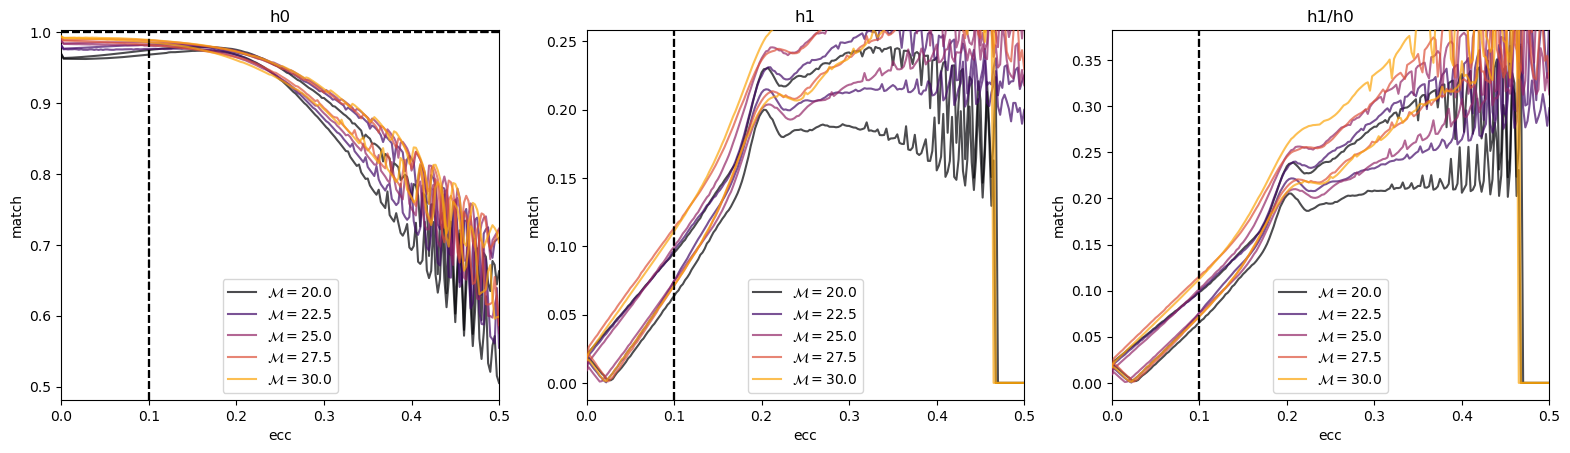

In [9]:
min_max_plot(grid_data_20_30_5_hfe)